# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>
## <font color='blue'>Mini-Projeto 7</font>
## <font color='blue'>Detecção de Objetos com YOLO</font>

![DSA](imagens/MP7.png)

## Instalando e Carregando Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.11.5


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
#!pip install -q opencv-python

In [4]:
#!pip install -q opencv-contrib-python

In [5]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy     : 1.24.3
matplotlib: 3.7.2
cv2       : 4.8.1



## Detecção de Objetos com YOLO

A Detecção de Objetos com YOLO (You Only Look Once) é uma abordagem de Visão Computacional que visa identificar e localizar objetos em imagens ou vídeos. YOLO é uma das técnicas mais populares e eficientes para essa tarefa, conhecida por sua velocidade e precisão. Vamos entender suas características principais:

**Visão Geral do YOLO**

You Only Look Once (YOLO): Como o nome sugere, YOLO realiza a detecção de objetos em uma única passagem pela imagem. Isso significa que, em vez de primeiro identificar regiões de interesse e depois classificar essas regiões (como fazem algumas outras técnicas), YOLO faz tudo de uma vez. Isso torna o YOLO extremamente rápido.

Rede Neural Convolucional (CNN): YOLO utiliza uma CNN para extrair características da imagem e fazer previsões sobre a localização e classe dos objetos.

**Funcionamento do YOLO**

Divisão da Imagem: A imagem é dividida em uma grade (por exemplo, 13x13 células). Cada célula da grade é responsável por detectar objetos cujo centro está dentro dessa célula.

Bounding Boxes e Classes: Para cada célula, a rede prevê várias bounding boxes (caixas delimitadoras) e pontuações de confiança para essas boxes. As pontuações refletem o quão confiante a rede está de que a box contém um objeto e o quão preciso é o box. Além disso, a rede prevê as probabilidades de classe para cada box.

Filtros e Limiares: São aplicados limiares de confiança e algoritmos de supressão de não-máximos para filtrar boxes com baixa confiança e eliminar boxes redundantes.

**Vantagens e Desvantagens**

Vantagens: A maior vantagem do YOLO é sua velocidade, tornando-o adequado para aplicações em tempo real. Além disso, tende a ter uma boa precisão geral na detecção de objetos.

Desvantagens: Em suas versões iniciais, YOLO era menos preciso na detecção de objetos pequenos em comparação com outras abordagens. No entanto, as versões mais recentes melhoraram significativamente nesse aspecto.

YOLO é amplamente utilizado em sistemas de vigilância, veículos autônomos, análise de tráfego, entre outras aplicações onde a detecção rápida e precisa de objetos é crucial.

Faça o download de uma versão pré-treinada do YOLO nos links abaixo e coloque na pasta yolo, na mesma pasta onde está este Jupyter Notebook.

https://pjreddie.com/media/files/yolov3.weights

https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg

https://github.com/pjreddie/darknet/blob/master/data/coco.names

In [7]:
# Carrega nomes das classes
with open("yolo/coco.names", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

In [8]:
print(class_names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [9]:
# Carrega o modelo YOLO
rede_dsa = cv2.dnn.readNet("yolo/yolov3.weights", "yolo/yolov3.cfg")

In [10]:
# Função para obter as saídas dos nomes das camadas
def get_output_layers(net):
    
    # Obtém os nomes de todas as camadas na rede neural 
    layer_names = net.getLayerNames()
    
    # Cria uma lista dos nomes das camadas de saída. 'net.getUnconnectedOutLayers()' retorna os índices 
    # das camadas de saída e esses índices são usados para acessar os nomes das camadas correspondentes 
    # em 'layer_names'
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    
    # Retorna a lista dos nomes das camadas de saída
    return output_layers

In [11]:
# Função para desenhar as caixas de detecção em uma imagem
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    
    # Converte o identificador da classe em uma string usando um array de nomes de classes
    label = str(class_names[class_id])

    # Gera uma cor aleatória para a caixa de detecção e o texto
    color = [float(c) for c in np.random.uniform(0, 255, size = (3,))]

    # Desenha uma caixa retangular na imagem 'img' com as coordenadas fornecidas e a cor gerada
    cv2.rectangle(img, (int(x), int(y)), (int(x_plus_w), int(y_plus_h)), color, 2)

    # Coloca um texto (nome da classe e confiança) na imagem, um pouco acima e à esquerda da caixa de detecção
    cv2.putText(img, label, (int(x)-10, int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [12]:
# Carregar uma imagem
image = cv2.imread('dados/imagem1.jpg')
#image = cv2.imread('dados/imagem2.png')
#image = cv2.imread('dados/imagem3.jpg')
#image = cv2.imread('dados/imagem4.png')
#image = cv2.imread('dados/imagem5.png')

In [13]:
# Extrai largura e altura
width, height = image.shape[1], image.shape[0]

In [14]:
# Escala de ajuste da imagem
scale = 0.00392

In [15]:
# Cria blob da imagem
blob = cv2.dnn.blobFromImage(image, scale, (416, 416), (0, 0, 0), True, crop = False)
rede_dsa.setInput(blob)

O código acima é utilizado para preparar uma imagem para ser processada por uma rede neural no contexto de visão computacional, utilizando a biblioteca OpenCV. Vamos analisar cada parte do código:

**blob = cv2.dnn.blobFromImage(image, scale, (416, 416), (0, 0, 0), True, crop = False):** Esta linha de código cria um blob a partir de uma imagem. Um blob é essencialmente uma coleção de imagens pré-processadas (neste caso, apenas uma) que podem ser passadas através da rede neural. Aqui estão os argumentos da função cv2.dnn.blobFromImage:

**image:** A imagem de entrada que você quer processar.

**scale:** Um fator de escala para normalizar os valores dos pixels. Por exemplo, se for 1/255, os pixels serão normalizados para o intervalo 0-1.

**(416, 416):** O tamanho para o qual a imagem será redimensionada. Isso depende do modelo de rede neural que você está utilizando. Por exemplo, muitos modelos YOLO utilizam imagens de 416x416 pixels.

**(0, 0, 0):** Os valores médios que serão subtraídos de cada canal da imagem. Isso é parte do processo de normalização.

**True:** Indica se a imagem deve ser convertida de BGR para RGB. OpenCV lê imagens no formato BGR por padrão, enquanto muitas redes neurais esperam imagens em RGB.

**crop = False:** Indica se a imagem deve ou não ser cortada após o redimensionamento.

**net.setInput(blob):** Esta linha define o blob como entrada da rede neural (net). Isso significa que o blob criado na linha anterior será usado como entrada para a rede neural para posterior processamento, como detecção de objetos, classificação, etc.

In [16]:
# Realiza a detecção e obtém as saídas
outs = rede_dsa.forward(get_output_layers(rede_dsa))

In [17]:
# Parâmetros de controle
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

In [18]:
# Processa as saídas da rede neural
for out in outs:
    
    # Itera sobre cada detecção na saída atual
    for detection in out:
        
        # Extrai as pontuações de confiança das classes a partir da detecção
        scores = detection[5:]

        # Encontra o índice da classe com a pontuação mais alta
        class_id = np.argmax(scores)

        # Obtém a pontuação de confiança para a classe com a pontuação mais alta
        confidence = scores[class_id]

        # Verifica se a pontuação de confiança está acima de um limiar definido
        if confidence > conf_threshold:
            
            # Calcula as coordenadas x e y do centro da caixa de detecção
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)

            # Calcula a largura e altura da caixa de detecção
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Calcula as coordenadas x e y do canto superior esquerdo da caixa de detecção
            x = center_x - w / 2
            y = center_y - h / 2

            # Adiciona o índice da classe à lista de class_ids
            class_ids.append(class_id)

            # Adiciona a pontuação de confiança à lista de confidences
            confidences.append(float(confidence))

            # Adiciona a caixa de detecção à lista de boxes
            boxes.append([x, y, w, h])

In [19]:
# Aplica non-max suppression para remover caixas redundantes
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

"Non-Max Suppression" (Supressão de Não-Máximos) é uma técnica usada em algoritmos de detecção de objetos, especialmente em Visão Computacional, para melhorar a precisão dos resultados. Quando um algoritmo de detecção de objetos é aplicado a uma imagem, é comum que ele identifique múltiplas caixas delimitadoras (bounding boxes) para um único objeto. Isso pode acontecer devido a várias sobreposições e variações nas caixas delimitadoras propostas pela rede neural. A Supressão de Não-Máximos é usada para resolver este problema, selecionando a caixa delimitadora mais apropriada para cada objeto detectado e descartando as caixas redundantes ou menos prováveis.

In [20]:
# Desenha as caixas finais na imagem
for i in indices:
    box = boxes[i]
    x, y, w, h = box[0], box[1], box[2], box[3]
    draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

In [21]:
# Converte a imagem BGR para RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

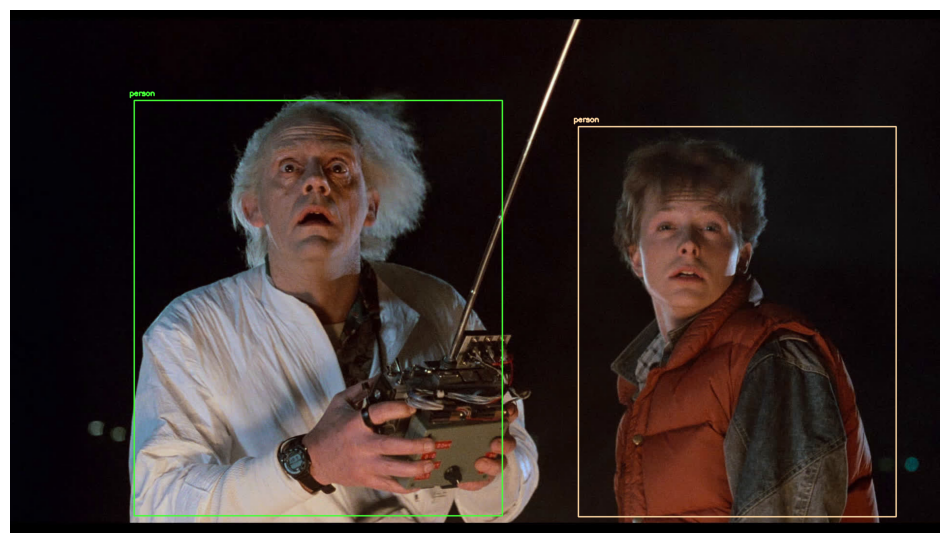

In [22]:
# Exibe a imagem usando matplotlib
plt.figure(figsize = (12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# Fim